# • Probabilistic Forecasts

Probabilistic forecasting is a natural answer to quantify the uncertainty of target variable's future. The task requires
to model the following conditional predictive distribution:

$$\mathbb{P}(\mathbf{y}_{t+1:t+H} \;|\; \mathbf{y}_{:t})$$

We will show you how to tackle the task with `NeuralForecast` by extending a classic [LSTM](https://arxiv.org/abs/2201.12886) and the [DilatedRNN](https://arxiv.org/abs/1905.10437) models combining them with the multi quantile loss function (MQLoss).

$$ \mathrm{MQLoss}(y_{\tau}, [\hat{y}^{(q1)}_{\tau},\hat{y}^{(q2)}_{\tau},\dots,\hat{y}^{(Q)}_{\tau}]) = \frac{1}{H} \sum_{q} \mathrm{QL}(y_{\tau}, \hat{y}^{(q)}_{\tau}) $$

In this notebook we will:
1. Install NeuralForecast Library
2. Explore the M4-Hourly data.
3. Train the LSTM and DilatedRNN
4. Visualize their M4 probabilistic predictions.

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/UncertaintyIntervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [1]:
%%capture
!pip install git+https://github.com/Nixtla/neuralforecast.git@main

In [2]:
import random
import warnings
warnings.filterwarnings("ignore")
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.models import LSTM, DilatedRNN

#### Useful functions

The `plot_grid` auxiliary function defined below will be useful to plot different time series, and different models' forecasts.

In [3]:
def plot_grid(df_train, df_test=None, plot_random=True, model=None, level=None):
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train')
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            for col in ['y', f'{model}-median', 'y_test']:
                if col in test_uid:
                    axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col)
            if level is not None:
                for l, alpha in zip(sorted(level), [0.5, .4, .35, .2]):
                    axes[idx, idy].fill_between(
                        test_uid['ds'], 
                        test_uid[f'{model}-lo-{l}.0'], 
                        test_uid[f'{model}-hi-{l}.0'],
                        alpha=alpha,
                        color='orange',
                        label=f'{model}_level_{l}',
                    )
        axes[idx, idy].set_title(f'M4 Hourly: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.5)
    plt.show()

## 2. Loading M4 Data

For testing purposes, we will use the Hourly dataset from the [M4 competition](https://www.researchgate.net/publication/325901666_The_M4_Competition_Results_findings_conclusion_and_way_forward).

In [4]:
%%capture
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv

In [5]:
Y_train_df = pd.read_csv('M4-Hourly.csv')
Y_test_df = pd.read_csv('M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In this example we will use a subset of the data to avoid waiting too long. You can modify the number of series if you want.

In [6]:
n_series = 8
uids = Y_train_df['unique_id'].unique()[:n_series]
Y_train_df = Y_train_df.query('unique_id in @uids')
Y_test_df = Y_test_df.query('unique_id in @uids')

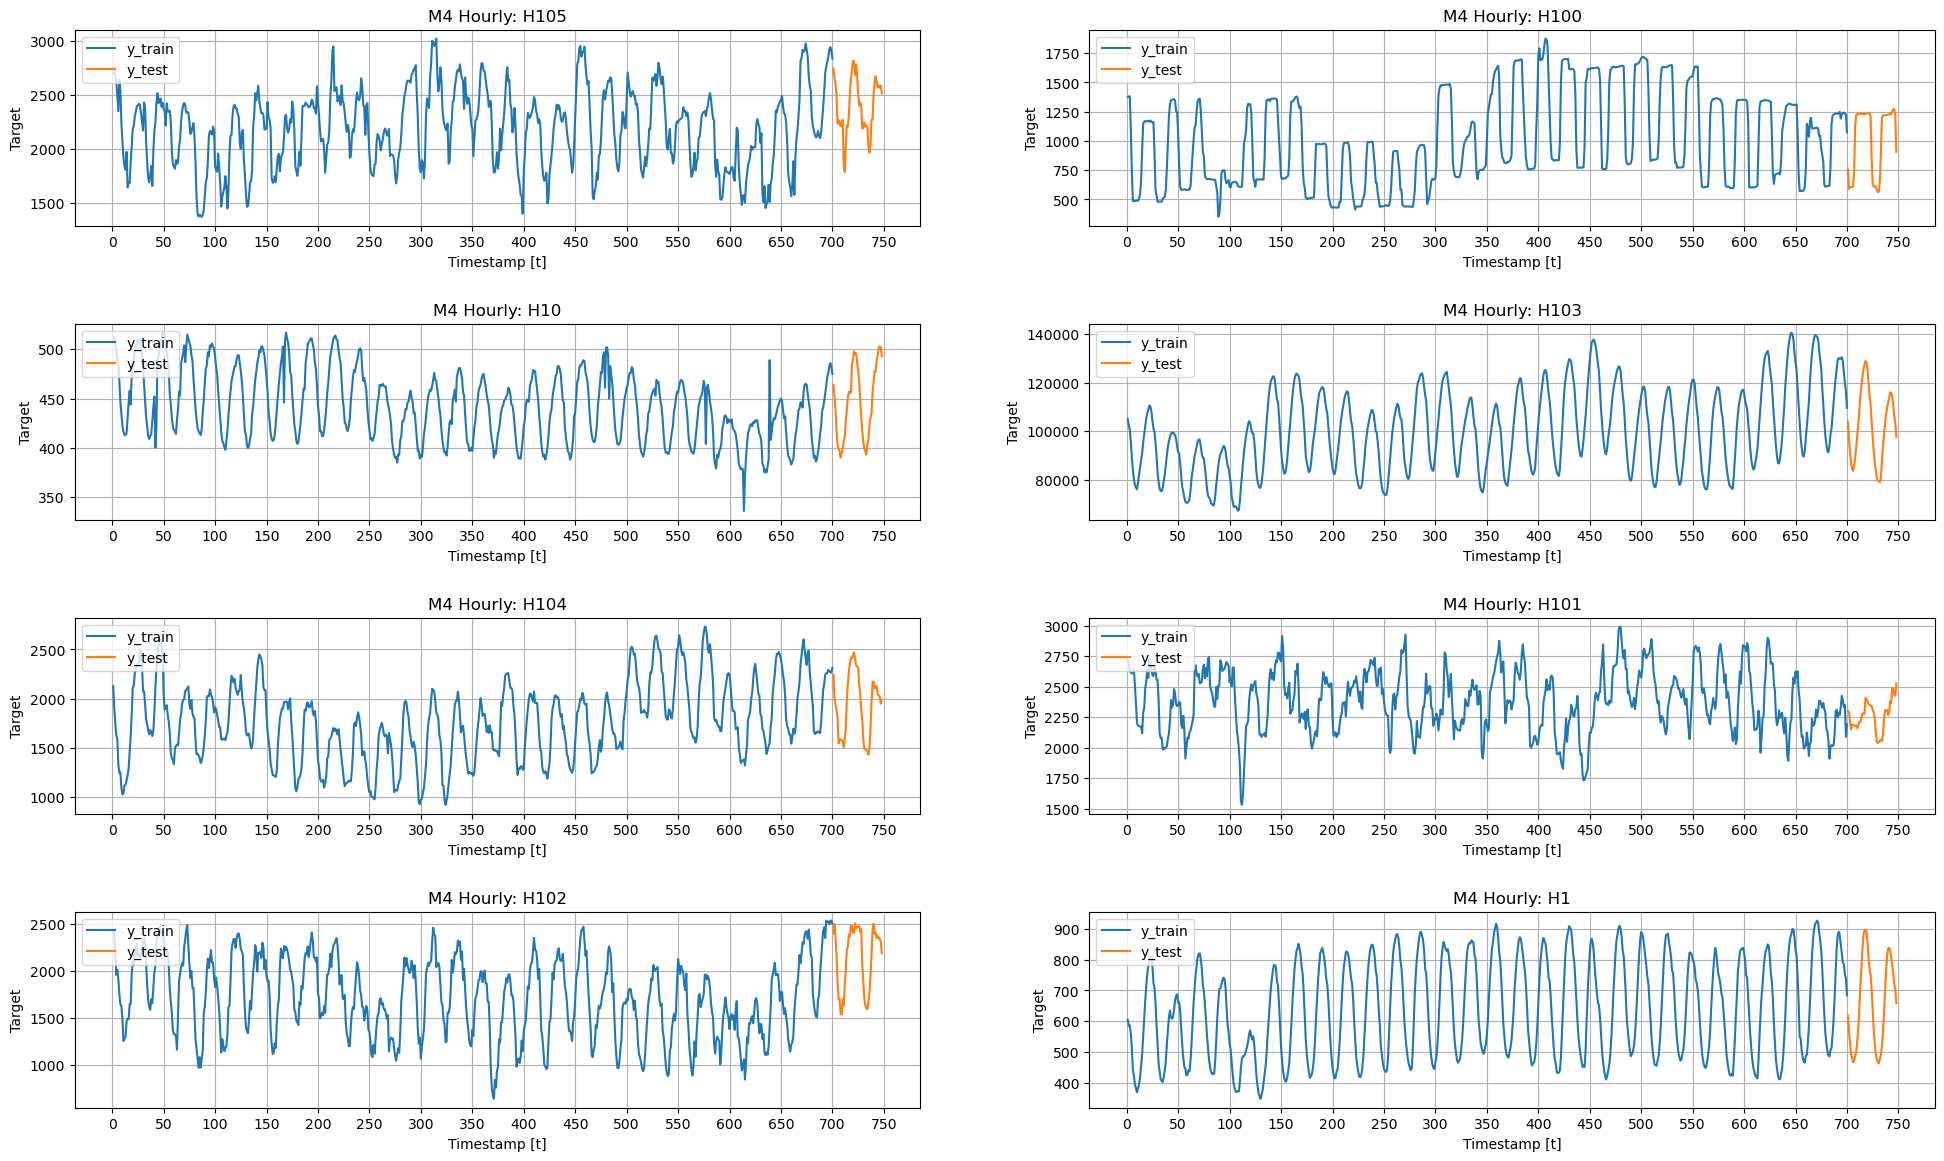

In [7]:
plot_grid(Y_train_df, Y_test_df)

## 3. Model Training

The `core.NeuralForecast` provides a high-level interface with our collection of PyTorch models. 
`NeuralForecast` is instantiated with a list of `models=[LSTM(...), DilatedRNN(...)]`, configured for the forecasting task.

- The `horizon` parameter controls the number of steps ahead of the predictions, in this example 48 hours ahead (2 days).
- The `MQLoss` with `levels=[80,90]` specializes the network's output into the 80% and 90% prediction intervals. 
- The `max_epochs=500`, controls the duration of the network's training.

For more network's instantiation details check their [documentation](https://nixtla.github.io/neuralforecast/models.dilated_rnn.html).

In [8]:
horizon = 48
levels = [80, 90]
models = [LSTM(input_size=-1, h=horizon,
               loss=MQLoss(level=levels), max_epochs=500),
          DilatedRNN(input_size=-1, h=horizon, 
                     cell_type='LSTM',
                     dilations=[[1, 2], [24, 48]],
                     loss=MQLoss(level=levels), max_epochs=500),]
fcst = NeuralForecast(models=models, freq='H')

The models are trained using cross-learning, that is a set of correlated series in `Y_train_df` is used during a shared optimization.

In [9]:
%%capture
fcst.fit(df=Y_train_df)

In [16]:
forecasts = fcst.predict()
forecasts = forecasts.reset_index()
forecasts.head()

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,LSTM-median,LSTM-lo-90.0,LSTM-lo-80.0,LSTM-hi-80.0,LSTM-hi-90.0,DilatedRNN-median,DilatedRNN-lo-90.0,DilatedRNN-lo-80.0,DilatedRNN-hi-80.0,DilatedRNN-hi-90.0
0,H1,701,621.826599,535.226013,558.130981,688.334229,715.735168,604.104797,519.419556,540.858459,676.904541,711.112244
1,H1,702,561.341858,450.997467,480.383484,646.750977,684.004211,552.682495,436.952759,471.723877,628.070923,665.441528
2,H1,703,511.724396,386.468964,428.669769,606.371216,640.975952,498.905365,375.128265,411.303955,592.815186,632.256531
3,H1,704,458.004425,336.626526,370.396942,555.223450,591.230896,450.909607,339.820496,365.699463,559.955505,596.015747
4,H1,705,439.166504,304.130127,346.339722,540.843506,572.304016,429.719604,304.976624,348.262482,533.294800,564.581848


In [13]:
Y_test_df = Y_test_df.merge(forecasts, how='left', on=['unique_id', 'ds'])

## 4. Plotting Predictions

Here we finalize our analysis by plotting the prediction intervals and verifying that both the `LSTM` and `DilatedRNN` are giving reasonable results.

Consider the output `[LSTM-lo-90.0`, `LSTM-hi-90.0]`, that represents the 80% prediction interval of the `LSTM` network; its lower limit gives the 5th percentile (or 0.05 quantile) while its upper limit gives the 95th percentile (or 0.95 quantile). For well-trained models we expect that the target values lie within the interval 90% of the time.

### LSTM

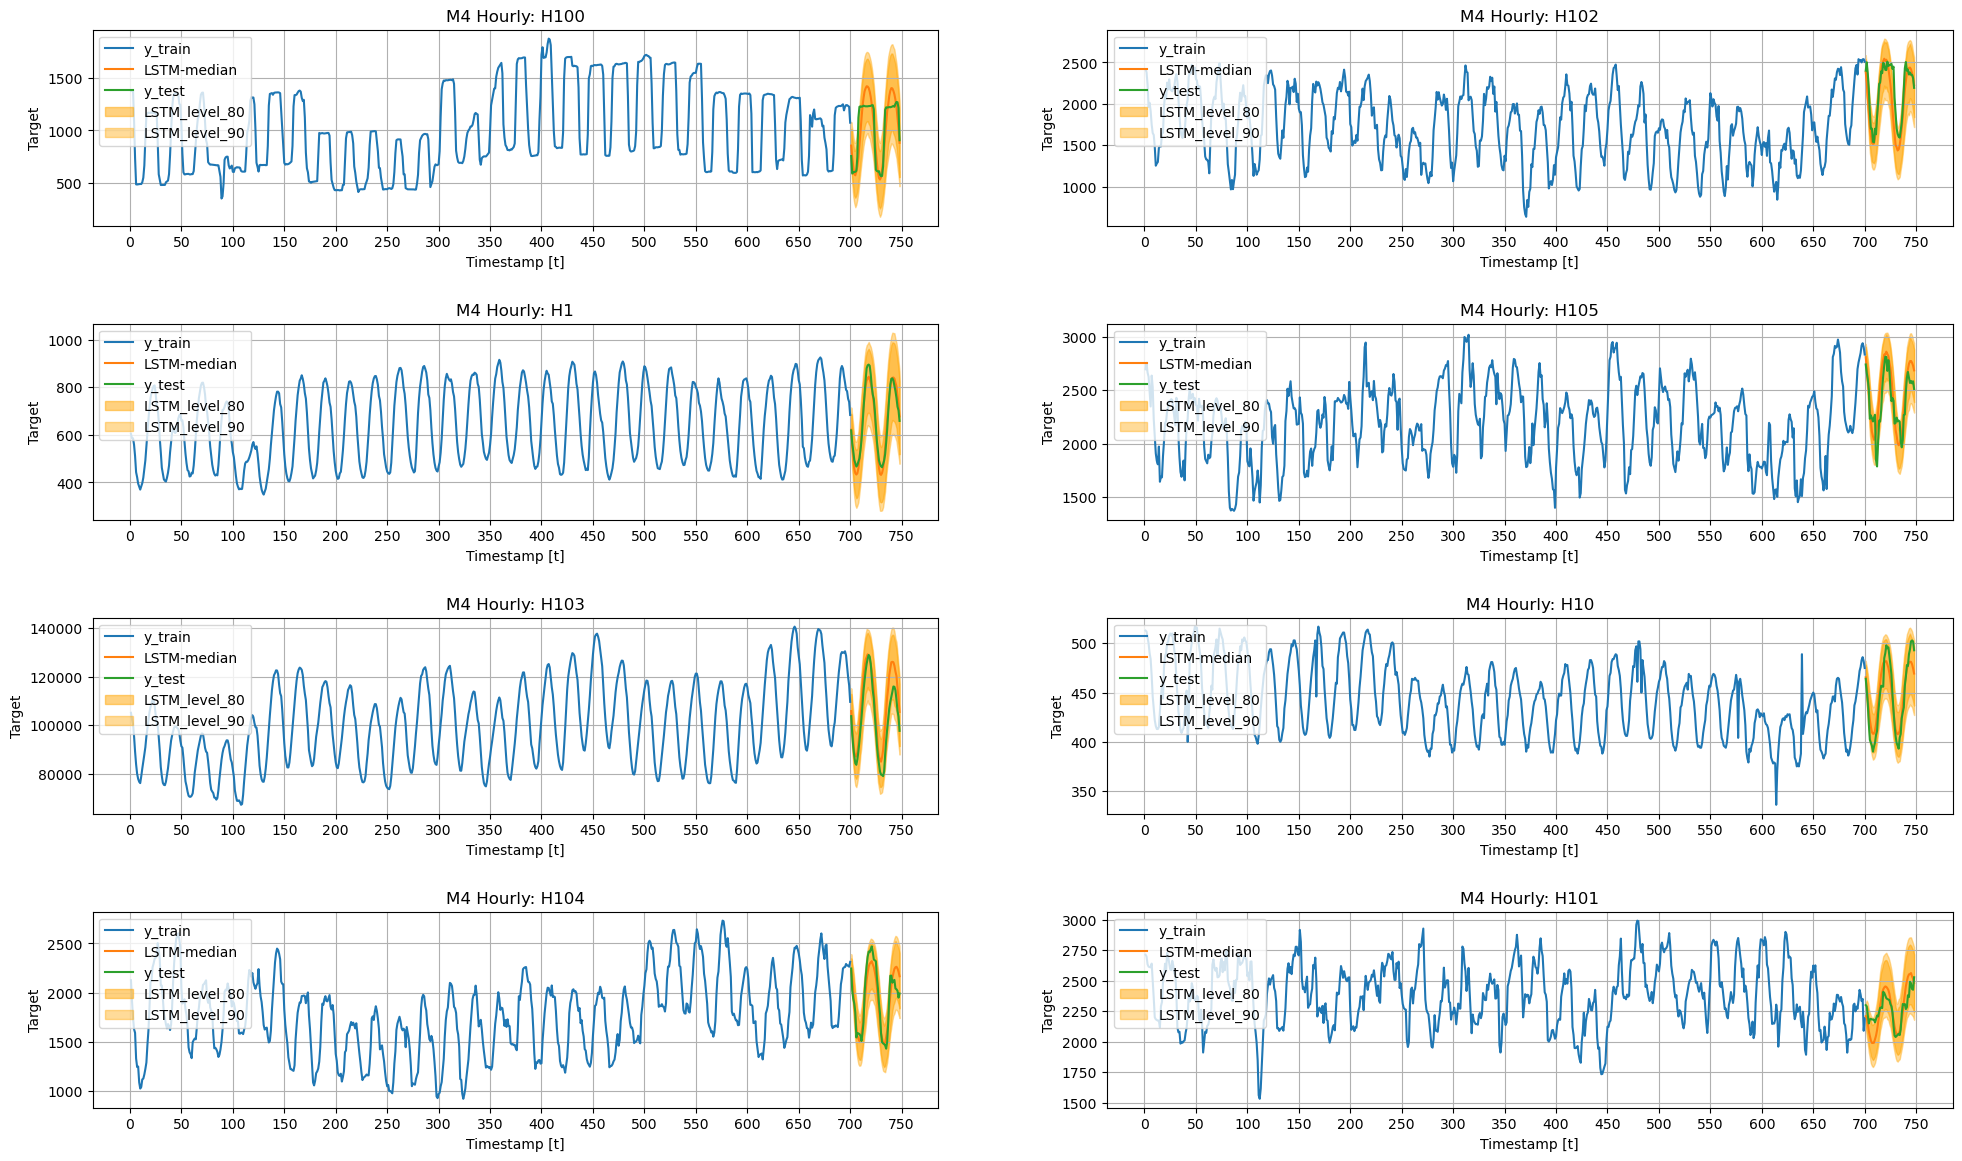

In [14]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='LSTM')

### DilatedRNN

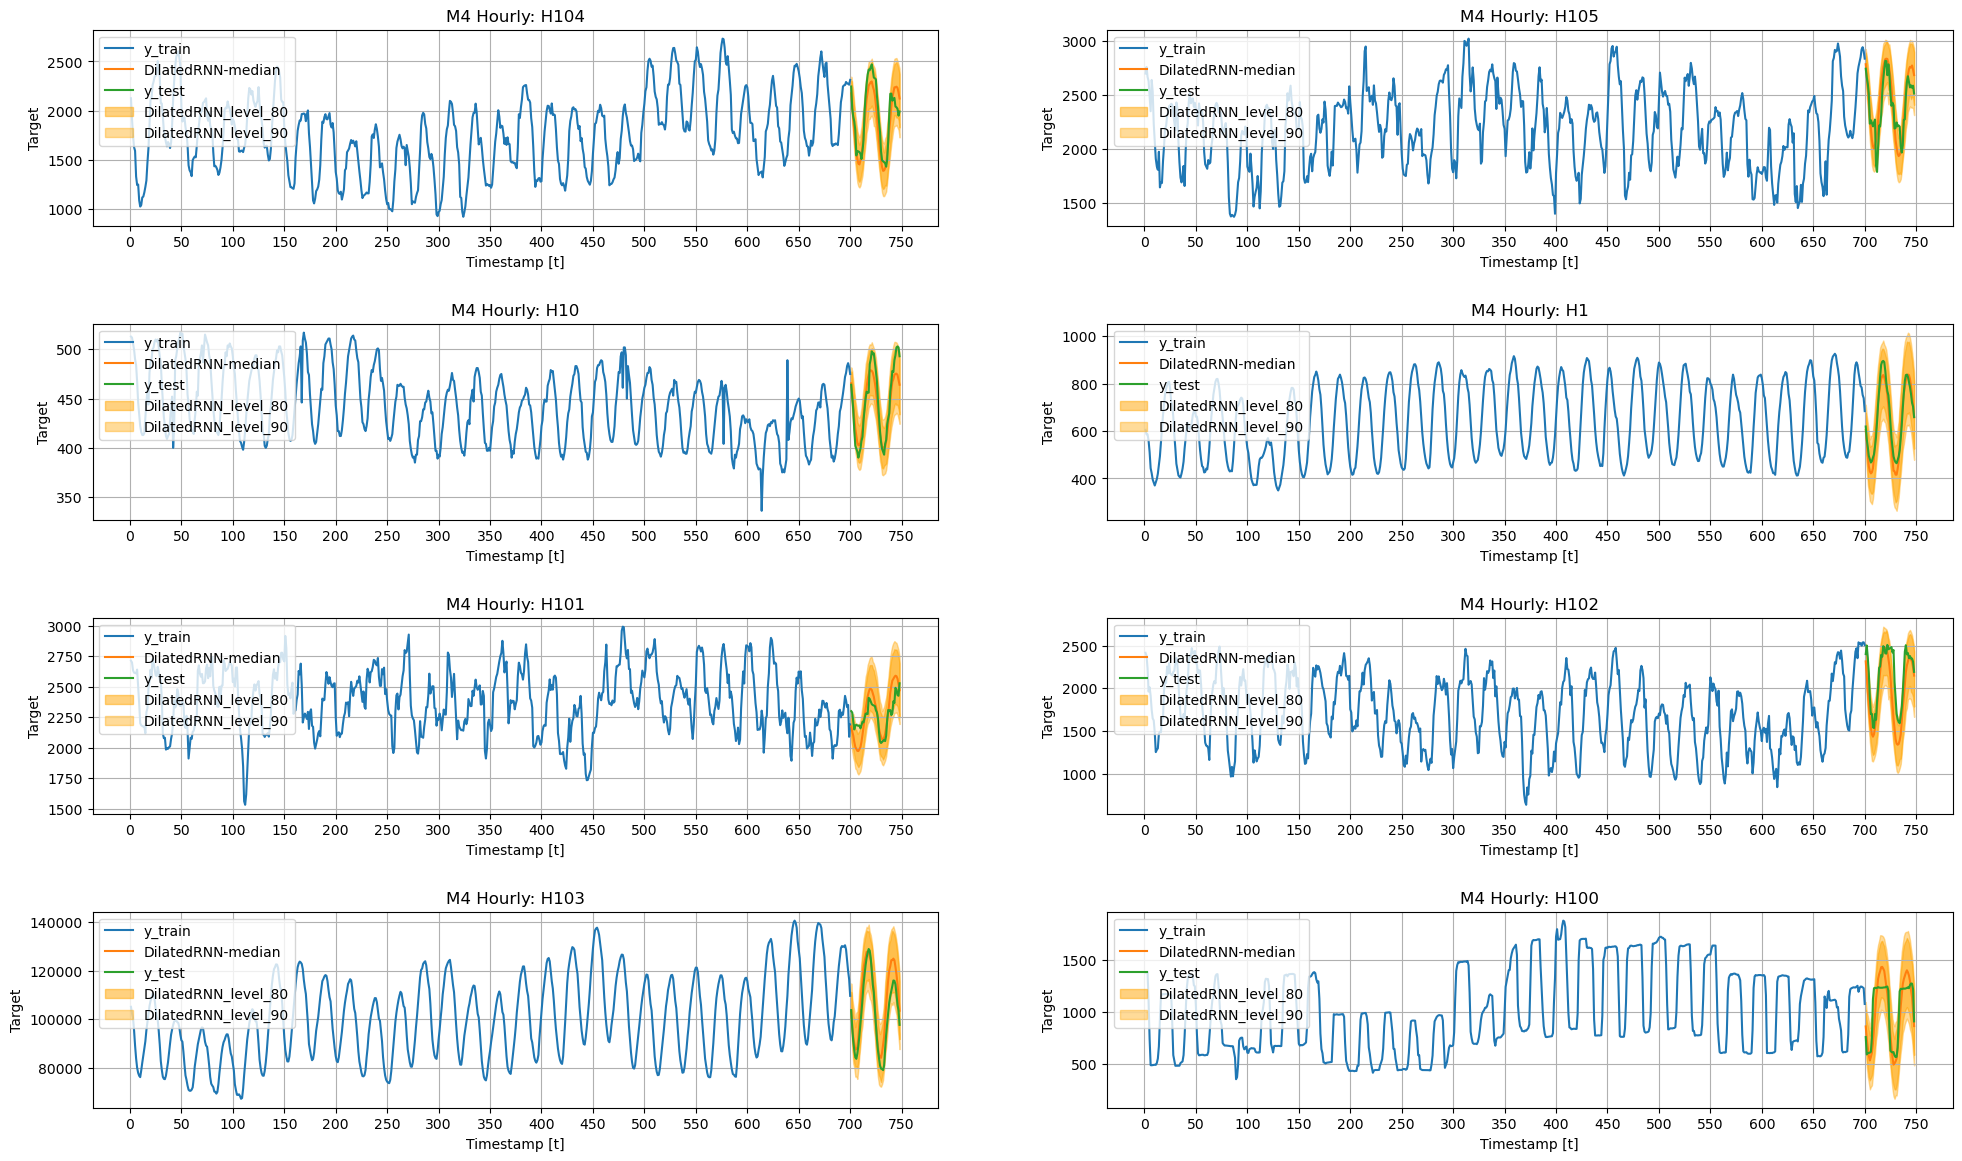

In [15]:
plot_grid(Y_train_df, Y_test_df, level=levels, model='DilatedRNN')

## References
- [Roger Koenker and Gilbert Basset (1978). Regression Quantiles, Econometrica.](https://www.jstor.org/stable/1913643)<br>
- [Jeffrey L. Elman (1990). "Finding Structure in Time".](https://onlinelibrary.wiley.com/doi/abs/10.1207/s15516709cog1402_1)<br>
- [Shiyu Chang, et al. "Dilated Recurrent Neural Networks".](https://arxiv.org/abs/1710.02224)<br>